## Goal
Apply Gradient Boosted Decision Trees and Random Forest on Amazon Food reviews.
1. Since both use Decision Trees as their base learners and DTs do not perform well with high dimension data (the number of vectors in BoW and tfIDF is large), apply DT on Average Word2Vec & tfIDF Word2Vec
2. Train/Test split using time based slicing as a 70-30 split
3. Use GridSearchCV to find the optimal number of base learners.
4. For GBDT use GridSearchCV to find the depth and learning rate as well.


### Data
The Amazon fine food reviews dataset is available [here](https://www.kaggle.com/snap/amazon-fine-food-reviews/downloads/database.sqlite/2). The SQLLite version(database.sqlite) of the dataset is used. A folder called 'amazon-fine-food-reviews' needs to be created in the working directory and downloaded to that folder.

Google Word2Vec (GoogleNews-vectors-negative300.bin) is also used and those are available [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus, collections
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer, roc_curve, auc
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD

import itertools, pickle, random, sqlite3, nltk, string, re
from pathlib import Path
from scipy import sparse
import scipy as sp

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec, KeyedVectors
from tqdm import tqdm
from datetime import datetime, timedelta

d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Load Data

In [3]:
# using the SQLite Table to read data.
con = sqlite3.connect('./amazon-fine-food-reviews/database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not considering those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [4]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#change reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print ('Total number of reviews is {} with {} features each'.format(*filtered_data.shape))
filtered_data.head()

Total number of reviews is 525814 with 10 features each


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### EDA

#### Remove Duplicates

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#### Data Cleanup

In [6]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

#### Note:
The dataset is imbalanced. So the metric to evaluate the model should not be accuracy, it could be confusion matrix 

### PreProcessing

#### Stemming, Stop word remove and Lemmatization

In [7]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print('The stop words are \n {}'.format(stop))
print('************************************************************')
print('The stem word for tasty is {}'.format(sno.stem('tasty')))

The stop words are 
 {'this', 'myself', 'how', "shouldn't", 'any', 'no', 'o', 'be', 'of', 'with', 'does', 'me', "couldn't", 'because', 'off', 'which', 'doesn', 'that', 'each', 'we', "needn't", 'our', 'a', 'he', "doesn't", 'these', 'm', "won't", 'same', "isn't", 'themselves', 'such', 'both', 't', 'yours', 'wouldn', 'only', 'mightn', "you're", 'ours', 'did', 'most', "that'll", 'isn', 'own', "weren't", "don't", 'what', 'ourselves', 'there', 'it', 'against', 'you', 'if', "wasn't", 'is', 'why', 'are', 'out', 'theirs', 'mustn', 'needn', 'ain', "shan't", 'should', 'by', 'his', 'who', 'am', 'my', 'about', 'below', 'more', 'ma', 'while', 'her', 'those', 'here', 'or', 'shouldn', 'other', 'll', 'some', 'before', "should've", 'd', 'to', 'couldn', 'then', 'whom', 'your', 'over', 'himself', 'him', 'in', 'into', 'as', 'were', 're', 'few', 'further', 'shan', 'up', 'under', "mustn't", 'until', "she's", 'than', 'aren', 'weren', 'hers', 'has', 'once', 'all', 'now', 'having', 'they', 'on', 'when', 'the', 

We need 3 types of cleaned data so we will use 3 different variables to store this data:
1. For Bag of Words and TfIDF we need the stop words to be removed and stemmed
2. For Bigrams and trigrams we do not need to remove the stop words but we can stem the words
3. For Avg Word2Vec and TfIDF Word2Vec we can remove the stopwords but not stem the words if we plan to use Google's word2vec model.

In [10]:
i=0
str_b=' '
str_n=' '
str_w=' '
bow_tfidf_string=[]
ngrams_string=[]
word2vec_string=[]
s=''
for sent in final['Text'].values:
    filtered_sentence_b=[]
    filtered_sentence_n=[]
    filtered_sentence_w=[]
    
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)): 
                s=(sno.stem(cleaned_words.lower())).encode('utf8')
                filtered_sentence_n.append(s) #for ngrams we need stemmed words
                if(cleaned_words.lower() not in stop):
                    filtered_sentence_b.append(s) #for BoW and tfidf we need stemmed and stop words removed data
                    filtered_sentence_w.append(cleaned_words.lower().encode('utf8')) # for Word2Vec we need non stemmed and stop words removed data
                else:
                    continue
            else:
                continue 
    
    
    str_n = b" ".join(filtered_sentence_n)
    str_b = b" ".join(filtered_sentence_b)
    str_w = b" ".join(filtered_sentence_w)
    
    bow_tfidf_string.append(str_b)
    ngrams_string.append(str_n)
    word2vec_string.append(str_w)

    i+=1

In [11]:
final['BowTfIDFText']=bow_tfidf_string 
final['BowTfIDFText']=final['BowTfIDFText'].str.decode("utf-8")

# final['nGramsText']=ngrams_string 
# final['nGramsText']=final['nGramsText'].str.decode("utf-8")

final['Word2VecText']=word2vec_string 
final['Word2VecText']=final['Word2VecText'].str.decode("utf-8")

In [12]:
# store final table into an SQlLite table for future.
final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
c=final_dbconn.cursor()
final_dbconn.text_factory = str
final.to_sql('Reviews', final_dbconn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

### Time Based Slicing
The below function creates a cross validation dataset and fits the model. This will be used across BoW, tfIDF, Average Word2Vec and tfIDF Word2Vec

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          figsize = (5,3),
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
def fit_predict(estimator, X_train, y_train, X_test, y_test):
    # fitting the model on crossvalidation train
    estimator.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    y_pred = estimator.predict(X_test)
    
    return y_pred

### Run Classifier
Given a dataset of X, y the below function
1. Splits the dataset into train and test.

In [3]:
def split_data(data, sort_by_time='Y', test_size=0.3):
    
    if sort_by_time == 'Y':
        data = data.sort_values(by='Time')
        data.reset_index(inplace=True,drop=True)
        
    train_index = int(np.floor(data.shape[0] * (1- test_size)))

    X_train = data.loc[:train_index]
    y_train = X_train.Score
    X_train.drop(['Score'], axis=1, inplace=True)
    

    X_test = data.loc[train_index:]
    y_test = X_test.Score
    X_test.drop(['Score'], axis=1, inplace=True)
    
    return X_train, y_train, X_test, y_test

In [4]:
def plot_cv_scores(gridsearch, param, x_axis_label, y_axis_label, title):
    X = [params[param] for params in gridsearch.cv_results_['params']]
    y = [mean for mean in gridsearch.cv_results_['mean_test_score']]
    
    plt.plot(X, y)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    
    plt.title(title)
    plt.grid() 

    plt.show()

In [5]:
def plot_roc_curve(fpr, tpr, roc_auc, y_label, x_label):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()

In [6]:
def print_top_n_features(feature_name, feature_importance, top_n):
    ex_dic = {
    'FeatureName': feature_name,
    'FeatureImp': feature_importance.tolist()
    }

    columns = ['FeatureName', 'FeatureImp']

    df = pd.DataFrame(ex_dic, columns=columns)
    df.sort_values(['FeatureImp'], ascending=False, inplace=True)
    print ('Top {} features are: \n {}'.format(top_n, df[0:top_n]))

In [7]:
def fit_and_visualize_trees(model, feature_names, file_name='tree.png'):
    export_graphviz(model, out_file=file_name)  
        
    # Visualize data
    dot_data = export_graphviz(model, 
                                   feature_names=feature_names,
                                   out_file=None,
                                   filled=True,
                                   rounded=True)
    graph = pydotplus.graph_from_dot_data(dot_data)

    colors = ('turquoise', 'orange')
    edges = collections.defaultdict(list)

    for edge in graph.get_edge_list():
        edges[edge.get_source()].append(int(edge.get_destination()))

    for edge in edges:
        edges[edge].sort()    
        for i in range(2):
            dest = graph.get_node(str(edges[edge][i]))[0]
            dest.set_fillcolor(colors[i])

    graph.write_png(file_name)

In [13]:
def do_paramSearch(model, param_grid, type_of_search, X_train, y_train, X_test, y_test, cv):
    if type_of_search not in ['GridSearch', 'RandomSearch']:
        print ('Allowed searches are GridSearch and RandomSearch')
        return
    
    #Use TimeSeriesSplit for cross validation
    tscv = TimeSeriesSplit(n_splits=cv)
    
    train_test_split = tscv.split(X_train)

    f1_scorer = make_scorer(f1_score, pos_label='positive')
    if type_of_search == 'GridSearch':
        gs = GridSearchCV(model, param_grid, cv = train_test_split, n_jobs=-1,verbose=5, scoring=f1_scorer)
    elif type_of_search == 'RandomSearch':
        gs = RandomizedSearchCV(model, param_grid, cv = train_test_split, n_jobs=-1,verbose=5, scoring=f1_scorer)
               
    gs.fit(X_train, y_train)
    
    print ('Calculating best score from grid search...')
    print ('Best score: ', gs.best_score_)

    print ('Best parameters set:')
    best_parameters = gs.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print (param_name, best_parameters[param_name])
        
    plot_cv_scores(gridsearch=gs, param='n_estimators', x_axis_label='Base Learners', y_axis_label='F1 Scores',\
                   title='Plot of # of Base Learners vs F1 Scores')
    
    if isinstance(model, GradientBoostingClassifier):
        plot_cv_scores(gridsearch=gs, param='learning_rate', x_axis_label='Learning Rate', y_axis_label='F1 Scores',\
                   title='Plot of Learning Rate vs F1 Scores')
        plot_cv_scores(gridsearch=gs, param='max_depth', x_axis_label='Max Depth', y_axis_label='F1 Scores',\
                   title='Plot of Max Depth vs F1 Scores')

    print ('Dimensions of X_test is {} and y_test is {}'.format (X_test.shape, y_test.shape))
    print ('Predicting with X_test.....')
    y_pred = gs.predict(X_test)

    print ('Classification report is .....')
    print (classification_report(y_test, y_pred))
    
    print ('Confusion Matrix is .....')
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, ['Negative', 'Positive'])
    
    return param_grid.keys(), best_parameters

In [27]:
def run_classifier(data, vectorize_technique, model_nm, k=5):
    if vectorize_technique not in ['bow', 'tfidf', 'Gavgw2v', 'Gtfidfw2v', 'Oavgw2v', 'Otfidfw2v']:
        print ('Allowed vectorization techniques are Bag Of Words(bow), TF-IDF(tfidf), \
                Average Word2Vec Using Google vectors(Gavgw2v), TF-IDF Word2Vec Using Google vectors(Gtfidfw2v), \
                Average Word2Vec Using Own Model(Oavgw2v), TF-IDF Word2Vec Using Own Model(Otfidfw2v)')
        return
    
    if model_nm not in ['GBDT', 'RF']:
        print ('Allowed models are Gradient Boosted Decision Trees(GBDT) and Random Forest(TF)')
        return
    
    X_train, y_train, X_test, y_test = split_data(data, sort_by_time='Y')
    
    #Create X_train with just the vectors
    if vectorize_technique == 'bow':
        X_train, X_test, vectorizer = vectorize_bow(X_train, X_test)
    elif vectorize_technique == 'tfidf':
        X_train, X_test, vectorizer = vectorize_tfidf(X_train, X_test)
    elif vectorize_technique == 'Gavgw2v':
        X_train, X_test = vectorize_Gavgw2v(X_train, X_test)
    elif vectorize_technique == 'Gtfidfw2v':
        X_train, X_test = vectorize_Gavgw2v(X_train, X_test)
    elif vectorize_technique == 'Oavgw2v':
        X_train, X_test = vectorize_Oavgw2v(X_train, X_test)
    elif vectorize_technique == 'Otfidfw2v':
        X_train, X_test = vectorize_Otfidfw2v(X_train, X_test)
        
    cv = 10
    
    if model_nm == 'RF':
        n_estimators = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    else:
        n_estimators = [40, 50, 60, 70, 80, 90]
        learning_rate= [0.01, 0.1]
        max_depth = [1, 2, 3, 4]
        
    sp.random.seed(123345)
    uniform_Cs=sp.random.uniform(low=10**0,high=10**2,size=4)
    uniform_gammas=sp.random.uniform(low=10**-7,high=10**-2,size=4)
    search_types = ['GridSearch']
    
    for search_type in search_types:
        if vectorize_technique in ('bow', 'tfidf'):
            max_features = int(X_train.shape[1]/2)
        else:
            max_features = None
        print ('Max features are {}'.format(max_features))
        
        if model_nm == 'RF':
            model = RandomForestClassifier(max_features=max_features)
            param_grid = {'n_estimators': n_estimators}
        else:
            model = GradientBoostingClassifier()
            param_grid = {'n_estimators': n_estimators, 'learning_rate': learning_rate, 'max_depth': max_depth}
            
        print ('\nDoing {} .....'.format(search_type))
        print ('-' *80)
        param_grid_keys, best_parameters = do_paramSearch(model, param_grid, search_type, X_train, y_train, X_test, y_test, cv)
        
        for param_name in sorted(param_grid_keys):
            print (param_name, best_parameters[param_name])
            if param_name == 'n_estimators':
                n_base_learners = best_parameters[param_name]
            if param_name == 'learning_rate':
                l_rate = best_parameters[param_name]
            if param_name == 'max_depth':
                depth = best_parameters[param_name]
    
        if vectorize_technique in ('bow', 'tfidf'):
            feature_names = vectorizer.get_feature_names()
            if isinstance(model, RandomForestClassifier):
                clf = RandomForestClassifier(max_features=max_features, n_estimators=n_base_learners)
            else:
                clf = GradientBoostingClassifier(max_features=max_features, n_estimators=n_base_learners, learning_rate=l_rate, max_depth=depth)
            clf = clf.fit(X_train, y_train)
            
            # Use the 1st estimator, which is a random selection, to visualize a tree from the enesemble model.
            if isinstance(model, RandomForestClassifier):
                est = clf.estimators_[1]
                md_name = 'RFClassifier'
            else:
                est = clf.estimators_[1, 0]
                md_name = 'GBDTClassifier'
            
            file_name = md_name + '-' + vectorize_technique + '-' + search_type + '-' +'tree.png'
            feature_names = vectorizer.get_feature_names()
            
            fit_and_visualize_trees(est, feature_names, file_name=file_name)

            
            print_top_n_features(feature_names, clf.feature_importances_, 10)
            return clf

## Bag of Words

In [10]:
def get_bow_tfidfdata(no_of_records = 2000, split_evenly=True):
    if split_evenly:
        pos_limit = int(no_of_records * 0.50)
        neg_limit = no_of_records - pos_limit
    else:
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
        pos_limit = int(no_of_records * 0.85)
        neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    pos_qry = "SELECT time, BowTfIDFText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT time, BowTfIDFText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))
    return data

In [11]:
def run_svd(X_train_cnts, X_test_cnts, reduce_to):
    svd = TruncatedSVD(n_components=reduce_to)

    print ('Shape of X train cnts before SVD is {}'.format(X_train_cnts.shape))
    X_train_red = svd.fit_transform(X_train_cnts)
    print ('Shape of X train cnts after SVD is {}'.format(X_train_red.shape))
    explained_ratio = svd.explained_variance_ratio_
    print ('The explained ratio with {} components is {}'.format(reduce_to, np.sum(explained_ratio)))
    
    X_test_red = svd.fit_transform(X_test_cnts)
    return X_train_red, X_test_red

def vectorize_bow(X_train, X_test):
    #Vectorize the reviews
    count_vect = CountVectorizer() 
    
    #Build vocabulary from X_train
    X_train_counts = count_vect.fit_transform(X_train['BowTfIDFText'].values)
    X_test_counts = count_vect.transform(X_test['BowTfIDFText'].values)
    
    print("Shape of vectorized train and test datasets are {} and {}".format(X_train_counts.get_shape(), X_test_counts.get_shape()) )
    print("Number of unique words in the dataset is ", X_train_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_train_counts))
    
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized Bag of Words review contains {} records with {} features each'.format(*X_train_std_data.shape))

    #vectorize the test set with the same vocabulary as train data set
    print("The shape of our BOW vectorized test dataset is {}".format(X_test_counts.get_shape()))

    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data, count_vect

13:12:23
Positive reviews shape is (2500, 3)
Negative reviews shape is (2500, 3)
Both positive and negative reviews combined together contains 5000 reviews
Shape of vectorized train and test datasets are (3501, 9053) and (1500, 9053)
Number of unique words in the dataset is  9053
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 3501 records with 9053 features each
The shape of our BOW vectorized test dataset is (1500, 9053)


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Max features are 4526

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.6min finished


Calculating best score from grid search...
Best score:  0.7737811868517434
Best parameters set:
n_estimators 80


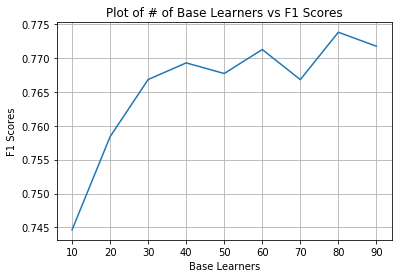

Dimensions of X_test is (1500, 9053) and y_test is (1500,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.84      0.80      0.82       781
   positive       0.79      0.84      0.82       719

avg / total       0.82      0.82      0.82      1500

Confusion Matrix is .....


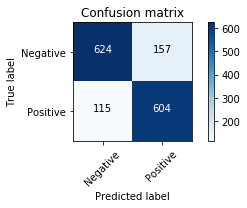

n_estimators 80
Top 10 features are: 
      FeatureName  FeatureImp
4585        love    0.064870
3402       great    0.029816
691         best    0.024105
7824        tast    0.022922
1169         cat    0.019290
2281         dog    0.016763
2184  disappoint    0.016735
4995        mole    0.011803
2674       excel    0.010505
3001        food    0.009384
13:16:14


In [28]:
# no_of_records=364171
no_of_records=5000
print (format(datetime.now(), '%H:%M:%S'))
data = get_bow_tfidfdata(no_of_records)
est = run_classifier(data, vectorize_technique ='bow', model_nm='RF')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

13:17:04
Positive reviews shape is (2500, 3)
Negative reviews shape is (2500, 3)
Both positive and negative reviews combined together contains 5000 reviews
Shape of vectorized train and test datasets are (3501, 9053) and (1500, 9053)
Number of unique words in the dataset is  9053
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 3501 records with 9053 features each
The shape of our BOW vectorized test dataset is (1500, 9053)


d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\Tools\Miniconda3\envs\py_3_6_5_keras\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Max features are 4526

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.9min finished


Calculating best score from grid search...
Best score:  0.7879218200303222
Best parameters set:
learning_rate 0.1
max_depth 4
n_estimators 90


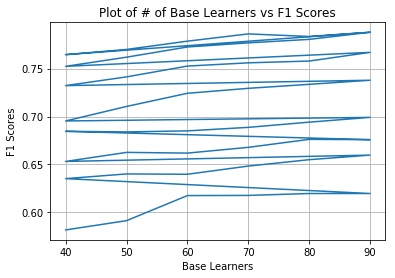

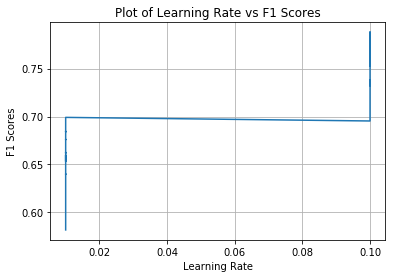

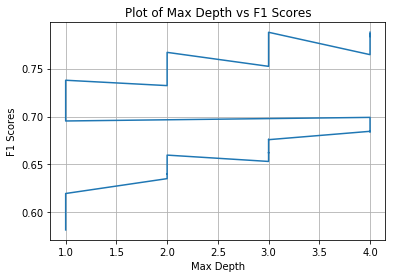

Dimensions of X_test is (1500, 9053) and y_test is (1500,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.83      0.82      0.83       781
   positive       0.81      0.82      0.82       719

avg / total       0.82      0.82      0.82      1500

Confusion Matrix is .....


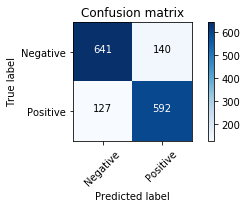

learning_rate 0.1
max_depth 4
n_estimators 90
Top 10 features are: 
      FeatureName  FeatureImp
4585        love    0.035978
3402       great    0.022451
2184  disappoint    0.021727
5010       money    0.020421
2281         dog    0.019937
7824        tast    0.018480
2809     favorit    0.016840
3001        food    0.015548
691         best    0.015301
8841        wine    0.014871
13:20:08


In [29]:
# no_of_records=364171
no_of_records=5000
print (format(datetime.now(), '%H:%M:%S'))
data = get_bow_tfidfdata(no_of_records)
run_classifier(data, vectorize_technique ='bow', model_nm='GBDT')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

## TF-IDF

In [30]:
def vectorize_tfidf(X_train, X_test):
    #Vectorize the reviews
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    
    #Build vocabulary from X_train
    X_train_counts = tf_idf_vect.fit_transform(X_train['BowTfIDFText'].values)
    X_test_counts = tf_idf_vect.transform(X_test['BowTfIDFText'].values)
    
    print("Shape of vectorized train and test datasets are {} and {}".format(X_train_counts.get_shape(), X_test_counts.get_shape()) )
    print("Number of unique words in the dataset is ", X_train_counts.get_shape()[1])
    print ('Type of bow_counts ', type(X_train_counts))
    
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized Bag of Words review contains {} with {} features each'.format(*X_train_std_data.shape))
    
    #vectorize the test set with the same vocabulary as train data set
    print("The shape of vectorized test dataset is {}".format(X_test_counts.get_shape()))
    
    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data, tf_idf_vect

13:21:14
Positive reviews shape is (2500, 3)
Negative reviews shape is (2500, 3)
Both positive and negative reviews combined together contains 5000 reviews
Shape of vectorized train and test datasets are (3501, 115523) and (1500, 115523)
Number of unique words in the dataset is  115523
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 3501 with 115523 features each
The shape of vectorized test dataset is (1500, 115523)
Max features are 57761

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 15.6min finished


Calculating best score from grid search...
Best score:  0.7745164270145711
Best parameters set:
n_estimators 50


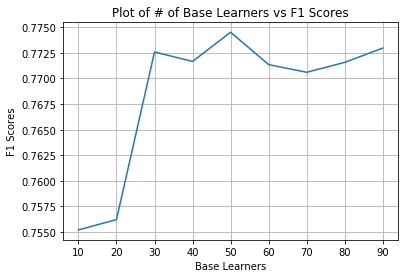

Dimensions of X_test is (1500, 115523) and y_test is (1500,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.85      0.77      0.81       781
   positive       0.78      0.85      0.81       719

avg / total       0.81      0.81      0.81      1500

Confusion Matrix is .....


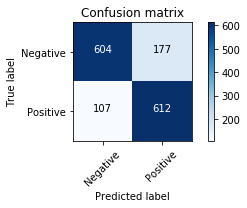

n_estimators 50
Top 10 features are: 
        FeatureName  FeatureImp
59275         love    0.074160
44195        great    0.031220
8719          best    0.023647
98928         tast    0.022454
15169          cat    0.019854
27627          dog    0.014800
64386        money    0.014268
26882   disappoint    0.013334
107441         use    0.010551
64077         mole    0.010502
13:38:47


In [31]:
no_of_records=5000
print (format(datetime.now(), '%H:%M:%S'))
data = get_bow_tfidfdata(no_of_records)
run_classifier(data, vectorize_technique ='tfidf', model_nm='RF')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

13:38:47
Positive reviews shape is (2500, 3)
Negative reviews shape is (2500, 3)
Both positive and negative reviews combined together contains 5000 reviews
Shape of vectorized train and test datasets are (3501, 115523) and (1500, 115523)
Number of unique words in the dataset is  115523
Type of bow_counts  <class 'scipy.sparse.csr.csr_matrix'>
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized Bag of Words review contains 3501 with 115523 features each
The shape of vectorized test dataset is (1500, 115523)
Max features are 57761

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 25.5min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 29.7min finished


Calculating best score from grid search...
Best score:  0.784808084147983
Best parameters set:
learning_rate 0.1
max_depth 4
n_estimators 90


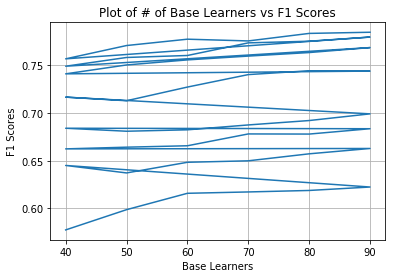

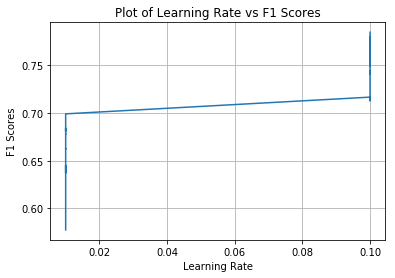

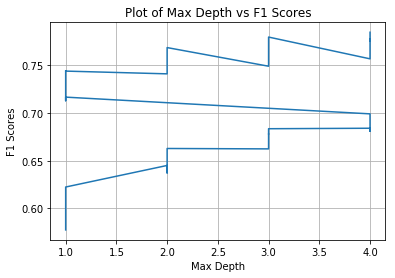

Dimensions of X_test is (1500, 115523) and y_test is (1500,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.84      0.80      0.82       781
   positive       0.79      0.83      0.81       719

avg / total       0.82      0.82      0.82      1500

Confusion Matrix is .....


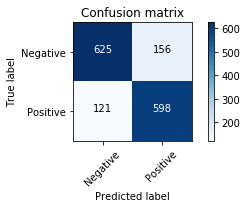

learning_rate 0.1
max_depth 4
n_estimators 90
Top 10 features are: 
        FeatureName  FeatureImp
59275         love    0.040995
44195        great    0.025439
98928         tast    0.023039
26882   disappoint    0.020605
64386        money    0.020271
38293         food    0.018130
64077         mole    0.016640
8719          best    0.016599
104509       treat    0.015427
27627          dog    0.014766
14:09:09


In [32]:
no_of_records=5000
print (format(datetime.now(), '%H:%M:%S'))
data = get_bow_tfidfdata(no_of_records)
run_classifier(data, vectorize_technique ='tfidf', model_nm='GBDT')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

## Word2Vec
There are 2 ways to do word2vec
1. Use Google's model which was built using Google's news dataset. Since this was built from a large dataset, this gives us a 300 dimension vector which will be richer.
2. Train our own model. Since we have a small dataset, we can build a 50 dimensional vector with this.
We will try both ways below

As a first step we need to build a list of sentence from the Word2VecText we have saved earlier. This will be used to get the vectors from Google's model as well as the one that we are going to build

In [33]:
def get_w2vdata(no_of_records = 2000, split_evenly=True):
    if split_evenly:
        pos_limit = int(no_of_records * 0.50)
        neg_limit = no_of_records - pos_limit
    else:
    #The original dataset has approximately 85% positive reviews and 15% negative reviews, so we will use the same % to make
    #a subset 
        pos_limit = int(no_of_records * 0.85)
        neg_limit = no_of_records - pos_limit

    final_dbconn = sqlite3.connect('./amazon-fine-food-reviews/finaldb.sqlite')
    final_dbconn.text_factory = str

    pos_qry = "SELECT time, Word2VecText, Score FROM Reviews where Score = 'positive' LIMIT " + str(pos_limit)
    pos_reviews = pd.read_sql_query(pos_qry, final_dbconn) 
    print('Positive reviews shape is {}'.format(pos_reviews.shape))

    neg_qry = "SELECT time, Word2VecText, Score FROM Reviews where Score = 'negative' LIMIT " + str(neg_limit)
    neg_reviews = pd.read_sql_query(neg_qry, final_dbconn) 
    print('Negative reviews shape is {}'.format(neg_reviews.shape))

    frames = [pos_reviews, neg_reviews]

    data = pd.concat(frames, ignore_index=True)
    print('Both positive and negative reviews combined together contains {} reviews'.format(data.shape[0]))

    return data

#### Train our own Word2Vec model

In [34]:
def build_word2vec(train_list_of_sent):
    # Train your own Word2Vec model using your own text corpus
    w2v_model=Word2Vec(train_list_of_sent,min_count=5,size=50, workers=4)

    w2v_words = list(w2v_model.wv.vocab)
    return w2v_model, w2v_words

#### Average Word2Vec With our own model

In [35]:
def vectorize_Oavgw2v(X_train, X_test):
    train_list_of_sent=[]
    test_list_of_sent=[]
    print ('Splitting train data into sentences.....')
    for sent in X_train['Word2VecText'].values:
        train_list_of_sent.append(sent.split())
    
    print ('Splitting test data into sentences.....')
    for sent in X_test['Word2VecText'].values:
        test_list_of_sent.append(sent.split())
        
    print ('Building our word model.....')
    w2v_model, w2v_words = build_word2vec(train_list_of_sent)

    print ('Vectorizing train data.....')
    print('Starting vectorizing at {}'. format(datetime.now()))
    
    train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in train_list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        train_sent_vectors.append(sent_vec)

    print ('Vectorizing test data.....')
    print('Starting vectorizing at {}'. format(datetime.now()))
    test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in test_list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        test_sent_vectors.append(sent_vec)
    print('Completed vectorizing at {}'. format(datetime.now()))
    
    #convert to sparse matrix
    X_train_counts = sparse.csr_matrix(np.array(train_sent_vectors))
    X_test_counts = sparse.csr_matrix(np.array(test_sent_vectors))
        
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized reviews contain {} with {} features each'.format(*X_train_std_data.shape))
    
    #vectorize the test set with the same vocabulary as train data set
    print("The shape of vectorized test dataset is {}".format(X_test_counts.get_shape()))
    
    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data

14:09:09
Positive reviews shape is (50000, 3)
Negative reviews shape is (50000, 3)
Both positive and negative reviews combined together contains 100000 reviews
Splitting train data into sentences.....
Splitting test data into sentences.....
Building our word model.....
Vectorizing train data.....
Starting vectorizing at 2018-11-05 14:10:05.339685
Vectorizing test data.....
Starting vectorizing at 2018-11-05 14:12:13.401495
Completed vectorizing at 2018-11-05 14:13:18.575848
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 70001 with 50 features each
The shape of vectorized test dataset is (30000, 50)
Max features are None

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 125.0min finished


Calculating best score from grid search...
Best score:  0.8295610617824514
Best parameters set:
n_estimators 70


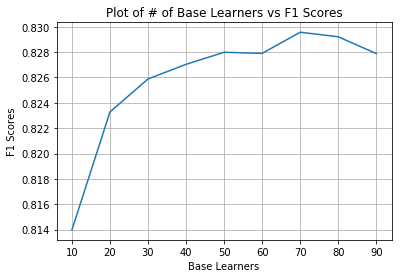

Dimensions of X_test is (30000, 50) and y_test is (30000,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.89      0.83      0.86     18875
   positive       0.74      0.83      0.79     11125

avg / total       0.84      0.83      0.83     30000

Confusion Matrix is .....


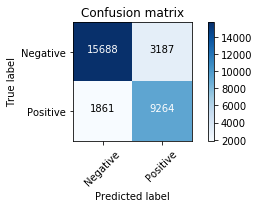

n_estimators 70
16:38:19


In [36]:
# no_of_records=364171
no_of_records=100000

print (format(datetime.now(), '%H:%M:%S'))
data = get_w2vdata(no_of_records)
run_classifier(data, vectorize_technique ='Oavgw2v', model_nm='RF')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

16:47:22
Positive reviews shape is (50000, 3)
Negative reviews shape is (50000, 3)
Both positive and negative reviews combined together contains 100000 reviews
Splitting train data into sentences.....
Splitting test data into sentences.....
Building our word model.....
Vectorizing train data.....
Starting vectorizing at 2018-11-05 16:47:37.903751
Vectorizing test data.....
Starting vectorizing at 2018-11-05 16:51:09.347466
Completed vectorizing at 2018-11-05 16:52:41.412049
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 70001 with 50 features each
The shape of vectorized test dataset is (30000, 50)
Max features are None

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 62.3min finished


Calculating best score from grid search...
Best score:  0.8358837575906423
Best parameters set:
learning_rate 0.1
max_depth 4
n_estimators 90


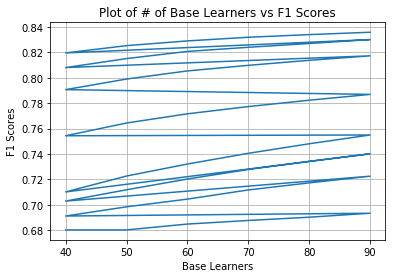

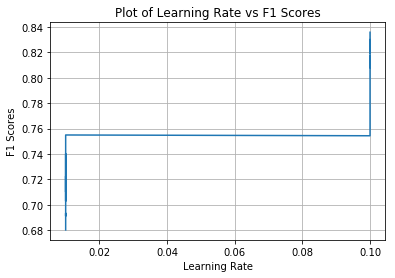

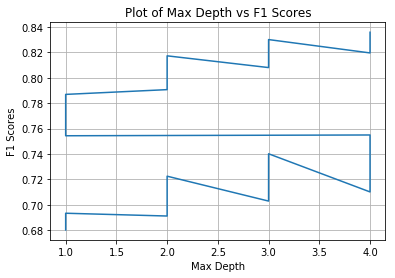

Dimensions of X_test is (30000, 50) and y_test is (30000,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.90      0.83      0.86     18875
   positive       0.74      0.85      0.79     11125

avg / total       0.84      0.84      0.84     30000

Confusion Matrix is .....


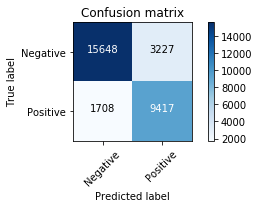

learning_rate 0.1
max_depth 4
n_estimators 90
18:06:31


In [37]:
no_of_records=100000

print (format(datetime.now(), '%H:%M:%S'))
data = get_w2vdata(no_of_records)
run_classifier(data, vectorize_technique ='Oavgw2v', model_nm='GBDT')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

#### TF-IDF weighted Word2Vec With our own model

In [38]:
def vectorize_Otfidfw2v(X_train, X_test):
    # TF-IDF weighted Word2Vec
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
    tf_idf_counts = tf_idf_vect.fit_transform(X_train['Word2VecText'].values)
    
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))


    tfidf_feat = tf_idf_vect.get_feature_names() 
    
    train_list_of_sent=[]
    test_list_of_sent=[]
    print ('Splitting train data into sentences.....')
    for sent in X_train['Word2VecText'].values:
        train_list_of_sent.append(sent.split())
    
    print ('Splitting test data into sentences.....')
    for sent in X_test['Word2VecText'].values:
        test_list_of_sent.append(sent.split())
        
    print ('Building our word model.....')
    w2v_model, w2v_words = build_word2vec(train_list_of_sent)
    
    print ('Vectorizing train data.....')
    train_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in train_list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
#                 tf_idf = tf_idf_counts[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        train_sent_vectors.append(sent_vec)
        row += 1

    print ('Vectorizing test data.....')
    test_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in test_list_of_sent: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                # obtain the tf_idfidf of a word in a sentence/review
#                 tf_idf = tf_idf_counts[row, tfidf_feat.index(word)]
                tf_idf = dictionary[word]*sent.count(word)
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        test_sent_vectors.append(sent_vec)
        row += 1

    X_train_counts = sparse.csr_matrix(np.array(train_sent_vectors))
    X_test_counts = sparse.csr_matrix(np.array(test_sent_vectors))
        
    X_train_std_data = StandardScaler(with_mean = False).fit_transform(X_train_counts)
    print ('Type of std_bow_data is {}'.format(type(X_train_std_data)))
    print ('Standardized reviews contain {} with {} features each'.format(*X_train_std_data.shape))
    
    #vectorize the test set with the same vocabulary as train data set
    print("The shape of vectorized test dataset is {}".format(X_test_counts.get_shape()))
    
    X_test_std_data = StandardScaler(with_mean = False).fit_transform(X_test_counts)
    return X_train_std_data, X_test_std_data

18:06:31
Positive reviews shape is (50000, 3)
Negative reviews shape is (50000, 3)
Both positive and negative reviews combined together contains 100000 reviews
Splitting train data into sentences.....
Splitting test data into sentences.....
Building our word model.....
Vectorizing train data.....
Vectorizing test data.....
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 70001 with 50 features each
The shape of vectorized test dataset is (30000, 50)
Max features are None

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 55.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 265.7min finished


Calculating best score from grid search...
Best score:  0.8125886031554586
Best parameters set:
n_estimators 90


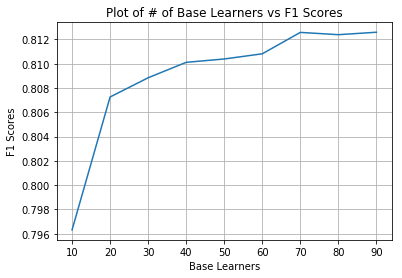

Dimensions of X_test is (30000, 50) and y_test is (30000,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.89      0.80      0.84     18875
   positive       0.71      0.83      0.76     11125

avg / total       0.82      0.81      0.81     30000

Confusion Matrix is .....


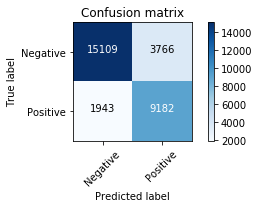

n_estimators 90
22:59:55


In [39]:
# no_of_records=364171
no_of_records=100000

print (format(datetime.now(), '%H:%M:%S'))
data = get_w2vdata(no_of_records)
run_classifier(data, vectorize_technique ='Otfidfw2v', model_nm='RF')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

08:39:47
Positive reviews shape is (50000, 3)
Negative reviews shape is (50000, 3)
Both positive and negative reviews combined together contains 100000 reviews
Splitting train data into sentences.....
Splitting test data into sentences.....
Building our word model.....
Vectorizing train data.....
Vectorizing test data.....
Type of std_bow_data is <class 'scipy.sparse.csr.csr_matrix'>
Standardized reviews contain 70001 with 50 features each
The shape of vectorized test dataset is (30000, 50)
Max features are None

Doing GridSearch .....
--------------------------------------------------------------------------------
Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 49.0min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 61.7min finished


Calculating best score from grid search...
Best score:  0.8154347432285298
Best parameters set:
learning_rate 0.1
max_depth 4
n_estimators 90


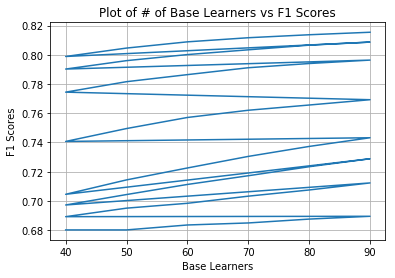

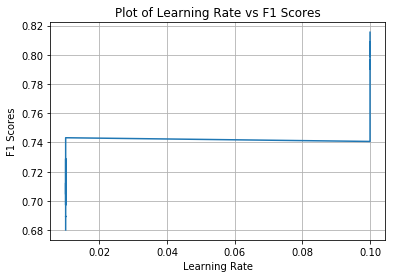

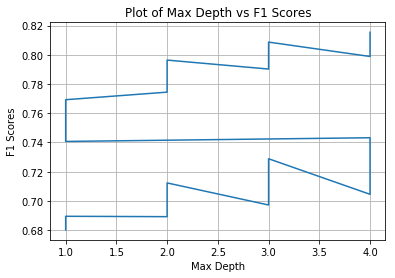

Dimensions of X_test is (30000, 50) and y_test is (30000,)
Predicting with X_test.....
Classification report is .....
             precision    recall  f1-score   support

   negative       0.89      0.78      0.84     18875
   positive       0.70      0.84      0.76     11125

avg / total       0.82      0.81      0.81     30000

Confusion Matrix is .....


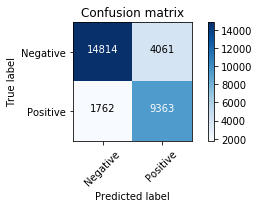

learning_rate 0.1
max_depth 4
n_estimators 90
09:48:23


In [40]:
no_of_records=100000
print (format(datetime.now(), '%H:%M:%S'))
data = get_w2vdata(no_of_records)
run_classifier(data, vectorize_technique ='Otfidfw2v', model_nm='GBDT')
ist = datetime.now()
print (format(ist, '%H:%M:%S'))

### Pseudo-code
1. Get featurized data.
2. Split data into train and test.
3. Vectorize train and test data using techniques such as BoW, TFIDF, Average Word2Vec or TFIDF Weighted Average Word2Vec.
4. Define range of hyperparams to be used by GridSearchCV.
5. Define model - either RandomForestClassifier or GradientBosstingClassifier.
6. Do GridSearchCV to find the right hyperparams.
7. Plot CV scores for the diferent hyperparams.
8. Predict with test data.
9. Print confusion matrix.
10. Use the best fit hyperparams and define another model to visualize trees and to print top 10 useful words.

### Results

|Model|Vectorization Technique|Best Parameters |Train F1 Score|Test F1 Score|Top 10 words|
|---:| ------------- |:-------------:| -----:|-----:|-----:|-----:|
|Random Forest|Bag Of Words|n_estimators - 80|0.773781186851743|0.82|love, great, best, tast, cat, dog, disappoint, mole, excel, food|
|GBDT|Bag Of Words|learning_rate - 0.1; max_depth - 4; n_estimators - 90|0.787921820030322|0.82|love, great, disappoint, money, dog, tast, favorit, food, best, wine|
|Random Forest|TFIDF|n_estimators - 50|0.774516427014571|0.81|love, great, best, tast, cat, dog, money, disappoint, use, mole|
|GBDT|TFIDF|learning_rate - 0.1; max_depth - 4; n_estimators - 90|0.784808084147983|0.82|love, great, tast, disappoint, money, food, mole, best, treat, dog|
|Random Forest|Average W2V|n_estimators - 70|0.829561061782451|0.83|NA|
|GBDT|Average W2V|learning_rate - 0.1; max_depth - 4; n_estimators - 90|0.835883757590642|0.84|NA|
|Random Forest|TFIDF Weighted Avg W2V|n_estimators - 90 |0.812588603155458|0.81|NA|
|GBDT|TFIDF Weighted Avg W2V|learning_rate - 0.1; max_depth - 4; n_estimators - 90|0.8154347432285298|0.81|NA|
